In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


from tensorflow import keras
import tensorflow as tf

2023-07-21 14:28:48.246896: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-21 14:28:48.546220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 14:28:50.315068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 리눅스 한글 설정
plt.rc('font', family = 'NanumGothic')

In [3]:
df = pd.read_pickle('mywafer.pkl')

In [4]:
df_train = df[df['train_test_label']=='Training']
df_test = df[df['train_test_label']=='Test']
df_real = df[df['train_test_label'].isna()]

In [5]:
X_tr = df_train['wafermap_reshape'].apply(lambda x: np.array(x))

In [6]:
X_te = df_test['wafermap_reshape'].apply(lambda x: np.array(x))

In [7]:
X_test = np.array([x for x in X_te])

In [8]:
X_train = np.array([x for x in X_tr])

In [9]:
y_train = df_train['failure_type'].astype('category').cat.codes
y_test = df_test['failure_type'].astype('category').cat.codes

### CNN_model 불러오기

***1. m_cnn55는 kernel size가 (5,5) learning rate는 0.001***

***2. m_cnn33는 kernel size가 (3,3) learning rate는 0.001***

In [12]:
m_cnn55 = tf.keras.models.load_model('model_CNN.h5')
m_cnn33 = tf.keras.models.load_model('model_CNN33.h5')

In [13]:
m_cnn55.evaluate(X_test, y_test)

2023-07-16 15:39:33.416366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902


  35/3702 [..............................] - ETA: 17s - loss: 0.3054 - accuracy: 0.9536  

2023-07-16 15:39:35.227085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3702/3702 [==============================] - 20s 4ms/step - loss: 1.0204 - accuracy: 0.7480


[1.0203837156295776, 0.7480011582374573]

In [14]:
m_cnn33.evaluate(X_test, y_test)

3702/3702 [==============================] - 15s 4ms/step - loss: 1.2765 - accuracy: 0.7116


[1.2764838933944702, 0.7115792036056519]

## CNN모델은 kernel size가 (5,5)인것이 (3,3)인것 보다 좋은 정확도를 보인다.
### kernel size가 크면 좋은 성능을 보일까? ==> (10,10)으로 다시 만들어보자

In [19]:
# CNN kernel_size를 (10,10)으로 설정
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(10,10), activation = 'relu', input_shape=(80, 80, 1),
                       padding = 'valid', data_format = 'channels_last'), # 2D는 평면
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Conv2D(32, kernel_size = (10,10), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9)
])


model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
         optimizer = keras.optimizers.Adam(learning_rate = 0.001),
         metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 71, 71, 32)        3232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        102432    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               6

In [20]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10


2023-07-16 15:01:02.447169: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x558a3198a3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-16 15:01:02.447214: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-07-16 15:01:02.501586: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-16 15:01:02.896749: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1654/1654 [==============================] - 21s 10ms/step - loss: 0.2988 - accuracy: 0.9178
Epoch 2/10
1654/1654 [==============================] - 16s 10ms/step - loss: 0.1283 - accuracy: 0.9619
Epoch 3/10
1654/1654 [==============================] - 16s 10ms/step - loss: 0.0890 - accuracy: 0.9725
Epoch 4/10
1654/1654 [==============================] - 16s 10ms/step - loss: 0.0698 - accuracy: 0.9787
Epoch 5/10
1654/1654 [==============================] - 16s 10ms/step - loss: 0.0541 - accuracy: 0.9830
Epoch 6/10
1654/1654 [==============================] - 16s 10ms/step - loss: 0.0435 - accuracy: 0.9862
Epoch 7/10
1654/1654 [==============================] - 16s 10ms/step - loss: 0.0364 - accuracy: 0.9888
Epoch 8/10
1654/1654 [==============================] - 16s 10ms/step - loss: 0.0293 - accuracy: 0.9905
Epoch 9/10
1654/1654 [==============================] - 16s 10ms/step - loss: 0.0222 - accuracy: 0.9927
Epoch 10/10
1654/1654 [==============================] - 16s 10ms/step - lo

In [ ]:
model.save('model_CNN10.h5')

In [16]:
m_cnn10 = tf.keras.models.load_model('model_CNN10.h5')

In [17]:
m_cnn10.evaluate(X_test, y_test)

3702/3702 [==============================] - 17s 5ms/step - loss: 1.2267 - accuracy: 0.5837


[1.2266993522644043, 0.5836886167526245]

### 10,10으로 했을 때도 5,5보다 좋지 못한 성능을 보인다. kernel size를 10과 5사이에서 조율이 필요하다.
***1. learning rate는 0.001로 두고 kernel size를 8,8로 맞춰본다.***

In [31]:
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(8,8), activation = 'relu', input_shape=(80, 80, 1),
                       padding = 'valid', data_format = 'channels_last'), # 2D는 평면
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Conv2D(32, kernel_size = (8,8), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9)
])


model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
         optimizer = keras.optimizers.Adam(learning_rate = 0.001),
         metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 73, 73, 32)        2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 32)        65568     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [32]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
1654/1654 [==============================] - 19s 9ms/step - loss: 0.2756 - accuracy: 0.9242
Epoch 2/10
1654/1654 [==============================] - 16s 9ms/step - loss: 0.1173 - accuracy: 0.9643
Epoch 3/10
1654/1654 [==============================] - 16s 9ms/step - loss: 0.0836 - accuracy: 0.9738
Epoch 4/10
1654/1654 [==============================] - 16s 10ms/step - loss: 0.0675 - accuracy: 0.9790
Epoch 5/10
1654/1654 [==============================] - 16s 9ms/step - loss: 0.0523 - accuracy: 0.9831
Epoch 6/10
1654/1654 [==============================] - 16s 10ms/step - loss: 0.0400 - accuracy: 0.9873
Epoch 7/10
1654/1654 [==============================] - 15s 9ms/step - loss: 0.0312 - accuracy: 0.9902
Epoch 8/10
1654/1654 [==============================] - 15s 9ms/step - loss: 0.0266 - accuracy: 0.9916
Epoch 9/10
1654/1654 [==============================] - 15s 9ms/step - loss: 0.0226 - accuracy: 0.9927
Epoch 10/10
1654/1654 [==============================] - 15s 9ms/step -

In [33]:
model.save('model_CNN8.h5')

In [24]:
m_cnn8 = tf.keras.models.load_model('model_CNN8.h5')

In [25]:
m_cnn8.evaluate(X_test, y_test)

3702/3702 [==============================] - 17s 4ms/step - loss: 1.0979 - accuracy: 0.7371


[1.097948670387268, 0.7370594143867493]

### kernel size는 5,5가 가장 높은 정확도를 보여준다. 이제 5,5모델의 learning_rate를 바꿔보자

***1. learning rate 0.01***

***2. learning rate 0.0001***

***3. learning rate 0.00001***

In [36]:
#learning_rate = 0.01

model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(5,5), activation = 'relu', input_shape=(80, 80, 1),
                       padding = 'valid', data_format = 'channels_last'), # 2D는 평면
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Conv2D(32, kernel_size = (5,5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9)
])


model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
         optimizer = keras.optimizers.Adam(learning_rate = 0.01),
         metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 76, 76, 32)        832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9248)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [37]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
1654/1654 [==============================] - 17s 9ms/step - loss: 0.3598 - accuracy: 0.9050
Epoch 2/10
1654/1654 [==============================] - 14s 9ms/step - loss: 0.2724 - accuracy: 0.9274
Epoch 3/10
1654/1654 [==============================] - 14s 9ms/step - loss: 0.2500 - accuracy: 0.9326
Epoch 4/10
1654/1654 [==============================] - 14s 9ms/step - loss: 0.2352 - accuracy: 0.9357
Epoch 5/10
1654/1654 [==============================] - 14s 9ms/step - loss: 0.2245 - accuracy: 0.9387
Epoch 6/10
1654/1654 [==============================] - 14s 9ms/step - loss: 0.2166 - accuracy: 0.9418
Epoch 7/10
1654/1654 [==============================] - 14s 9ms/step - loss: 0.2099 - accuracy: 0.9420
Epoch 8/10
1654/1654 [==============================] - 14s 9ms/step - loss: 0.2022 - accuracy: 0.9451
Epoch 9/10
1654/1654 [==============================] - 14s 9ms/step - loss: 0.1892 - accuracy: 0.9480
Epoch 10/10
1654/1654 [==============================] - 14s 9ms/step - l

In [38]:
model.save('m_cnn5_rate001.h5')

In [12]:
m_cnn5_rate001 = tf.keras.models.load_model('m_cnn5_rate001.h5')

In [30]:
m_cnn5_rate001.evaluate(X_test, y_test)

3702/3702 [==============================] - 16s 4ms/step - loss: 5.8369 - accuracy: 0.4293


[5.836947441101074, 0.4293469488620758]

### learning_rate 0.01은 매우 낮은 정확도를 보인다.

In [37]:
#learning_rate = 0.0001
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(5,5), activation = 'relu', input_shape=(80, 80, 1),
                       padding = 'valid', data_format = 'channels_last'), # 2D는 평면
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Conv2D(32, kernel_size = (5,5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9)
])


model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
         optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
         metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 76, 76, 32)        832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9248)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [38]:
model.fit(X_test, y_test, epochs = 10)

Epoch 1/10


2023-07-16 15:52:07.407648: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x556312dc6d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-16 15:52:07.407694: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-07-16 15:52:07.474351: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-16 15:52:07.981290: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3702/3702 [==============================] - 37s 9ms/step - loss: 0.3127 - accuracy: 0.9350
Epoch 2/10
3702/3702 [==============================] - 32s 9ms/step - loss: 0.2258 - accuracy: 0.9425
Epoch 3/10
3702/3702 [==============================] - 32s 9ms/step - loss: 0.1887 - accuracy: 0.9500
Epoch 4/10
3702/3702 [==============================] - 32s 9ms/step - loss: 0.1687 - accuracy: 0.9534
Epoch 5/10
3702/3702 [==============================] - 32s 9ms/step - loss: 0.1531 - accuracy: 0.9566
Epoch 6/10
3702/3702 [==============================] - 32s 9ms/step - loss: 0.1399 - accuracy: 0.9590
Epoch 7/10
3702/3702 [==============================] - 32s 9ms/step - loss: 0.1287 - accuracy: 0.9610
Epoch 8/10
3702/3702 [==============================] - 32s 9ms/step - loss: 0.1202 - accuracy: 0.9625
Epoch 9/10
3702/3702 [==============================] - 32s 9ms/step - loss: 0.1135 - accuracy: 0.9641
Epoch 10/10
3702/3702 [==============================] - 32s 9ms/step - loss: 0.1072

In [41]:
model.save('model_cnn5_rate.h5')

In [12]:
m_cnn5_rate = tf.keras.models.load_model('model_cnn5_rate.h5')

In [13]:
m_cnn5_rate.evaluate(X_test, y_test)

2023-07-19 13:50:04.665813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902


  32/3702 [..............................] - ETA: 18s - loss: 0.1156 - accuracy: 0.9629  

2023-07-19 13:50:06.430200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3702/3702 [==============================] - 23s 5ms/step - loss: 0.0963 - accuracy: 0.9693


[0.09626504778862, 0.9692515730857849]

In [12]:
#learning_rate = 0.0001
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(5,5), activation = 'relu', input_shape=(80, 80, 1),
                       padding = 'valid', data_format = 'channels_last'), # 2D는 평면
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Conv2D(32, kernel_size = (5,5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9)
])


model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
         optimizer = keras.optimizers.Adam(learning_rate = 0.00001),
         metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 76, 76, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 34, 34, 32)        25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9248)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [13]:
model.fit(X_test, y_test, epochs = 10)

Epoch 1/10


2023-07-17 16:14:48.498771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-17 16:14:50.416938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-17 16:14:50.440436: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55963a05db60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-17 16:14:50.440480: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-07-17 16:14:50.484921: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-17 16:14:50.867461: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lif

3702/3702 [==============================] - 39s 8ms/step - loss: 0.3971 - accuracy: 0.9310
Epoch 2/10
3702/3702 [==============================] - 30s 8ms/step - loss: 0.3201 - accuracy: 0.9344
Epoch 3/10
3702/3702 [==============================] - 30s 8ms/step - loss: 0.2969 - accuracy: 0.9361
Epoch 4/10
3702/3702 [==============================] - 30s 8ms/step - loss: 0.2779 - accuracy: 0.9366
Epoch 5/10
3702/3702 [==============================] - 30s 8ms/step - loss: 0.2618 - accuracy: 0.9375
Epoch 6/10
3702/3702 [==============================] - 30s 8ms/step - loss: 0.2482 - accuracy: 0.9387
Epoch 7/10
3702/3702 [==============================] - 30s 8ms/step - loss: 0.2375 - accuracy: 0.9401
Epoch 8/10
3702/3702 [==============================] - 30s 8ms/step - loss: 0.2283 - accuracy: 0.9413
Epoch 9/10
3702/3702 [==============================] - 30s 8ms/step - loss: 0.2203 - accuracy: 0.9431
Epoch 10/10
3702/3702 [==============================] - 30s 8ms/step - loss: 0.2131

In [15]:
model.save('m_cnn5_rate2.h5')

In [16]:
cnn_rate2 = tf.keras.models.load_model('m_cnn5_rate2.h5')

In [17]:
cnn_rate2.evaluate(X_test, y_test)

3702/3702 [==============================] - 16s 4ms/step - loss: 0.2070 - accuracy: 0.9448


[0.20704811811447144, 0.944843590259552]

### 그러나, 최대한 parameter를 줄여야한다. 이 프로그램이 작은 기계에 들어가야하기 때문에
1. kernel size와 learning rate를 적절하게 줄여보자

In [7]:
# random 10개를 뽑아서 real데이터를 수동태깅하고, 수동으로 확인해보자.
# layer하나씩 가져와서 저장된 weights를 주고, 이미지 하나를 넣어서 나오는 것을 시각화 시켜보자
# 과적합하면 drop out 
# parameter를 최대한 줄여야한다.

In [105]:
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(10,10), activation = 'relu', input_shape=(80, 80, 1),
                       padding = 'valid', data_format = 'channels_last'), # 2D는 평면
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Conv2D(32, kernel_size = (10,10), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9)
])


model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
         optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
         metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 71, 71, 32)        3232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        102432    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               6

In [12]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10


2023-07-17 20:01:18.794100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-17 20:01:20.928524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-17 20:01:20.958559: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4678f6c900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-17 20:01:20.958616: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-07-17 20:01:21.039977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-17 20:01:21.479517: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lif

1654/1654 [==============================] - 27s 10ms/step - loss: 0.4300 - accuracy: 0.8844
Epoch 2/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.2458 - accuracy: 0.9328
Epoch 3/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.1801 - accuracy: 0.9485
Epoch 4/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.1393 - accuracy: 0.9581
Epoch 5/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.1156 - accuracy: 0.9641
Epoch 6/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.1010 - accuracy: 0.9683
Epoch 7/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.0890 - accuracy: 0.9720
Epoch 8/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.0752 - accuracy: 0.9756
Epoch 9/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.0684 - accuracy: 0.9782
Epoch 10/10
1654/1654 [==============================] - 17s 10ms/step - lo

In [13]:
model.save('model_ideal.h5')

In [14]:
m_ideal = tf.keras.models.load_model('model_ideal.h5')

In [23]:
m_ideal.evaluate(X_test, y_test)

3702/3702 [==============================] - 17s 5ms/step - loss: 0.4954 - accuracy: 0.8753


[0.4954163730144501, 0.8753260970115662]

In [11]:
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(8,8), activation = 'relu', input_shape=(80, 80, 1),
                       padding = 'valid', data_format = 'channels_last'), # 2D는 평면
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Conv2D(32, kernel_size = (8,8), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9)
])


model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
         optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
         metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 73, 73, 32)        2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 32)        65568     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [12]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10


2023-07-21 14:29:47.462473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-21 14:29:49.408083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-21 14:29:49.438697: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f61992d4da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-21 14:29:49.438763: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-07-21 14:29:49.496814: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-21 14:29:49.872985: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lif

1654/1654 [==============================] - 26s 11ms/step - loss: 0.4291 - accuracy: 0.8869
Epoch 2/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.2555 - accuracy: 0.9322
Epoch 3/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.1954 - accuracy: 0.9456
Epoch 4/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.1546 - accuracy: 0.9549
Epoch 5/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.1263 - accuracy: 0.9614
Epoch 6/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.1067 - accuracy: 0.9672
Epoch 7/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.0947 - accuracy: 0.9702
Epoch 8/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.0800 - accuracy: 0.9747
Epoch 9/10
1654/1654 [==============================] - 17s 10ms/step - loss: 0.0724 - accuracy: 0.9775
Epoch 10/10
1654/1654 [==============================] - 17s 10ms/step - lo

In [13]:
model.save('model_ideal2.h5')

In [14]:
m_ideal2 = tf.keras.models.load_model('model_ideal2.h5')

In [15]:
m_ideal2.evaluate(X_test, y_test)

3702/3702 [==============================] - 18s 5ms/step - loss: 0.8287 - accuracy: 0.7347


[0.8286961913108826, 0.7346785664558411]

### 딥러닝 CNN 모델 중 kernel size 는 (5,5), learning_rate는 0.0001(10e-4)모델이 지금까지 가장 이상적인 모델이다.

***1. df_real데이터의 태깅이 되어있지 않은 실제 데이터의 그림을 보고 직접 태깅을 하고 실제로 위 모델에 적용시켜 보자***

In [14]:
df_real.head()

,index,diesize,lotname,waferindex,waferdims,train_test_label,failure_type,check_tuple,wafermap_reshape
35,35,2460.0,lot2,11.0,"(53, 58)",NaN,NaN,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
45,45,2460.0,lot2,21.0,"(53, 58)",NaN,NaN,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
69,69,2460.0,lot3,20.0,"(53, 58)",NaN,NaN,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
120,120,2460.0,lot5,21.0,"(53, 58)",NaN,NaN,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
158,158,533.0,lot7,9.0,"(26, 26)",NaN,NaN,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [20]:
df_reals = df_real.sample(20, random_state = 10)

In [16]:
df_reals.drop(['index'], axis = 1, inplace = True)

In [36]:
def check_failure(df):
    ct, e = 0, 0
    fig, axes = plt.subplots(4,5, figsize = (20,20))
    for i in range(len(df)):
        index = df.index[i]
        data = df['wafermap_reshape']
        axes[e][ct].imshow(data[index], cmap = 'gray')
        ct += 1
        if (i == 4) | (i == 9) | (i==14):
            e += 1
            ct = 0

IndexError: index 5 is out of bounds for axis 0 with size 5

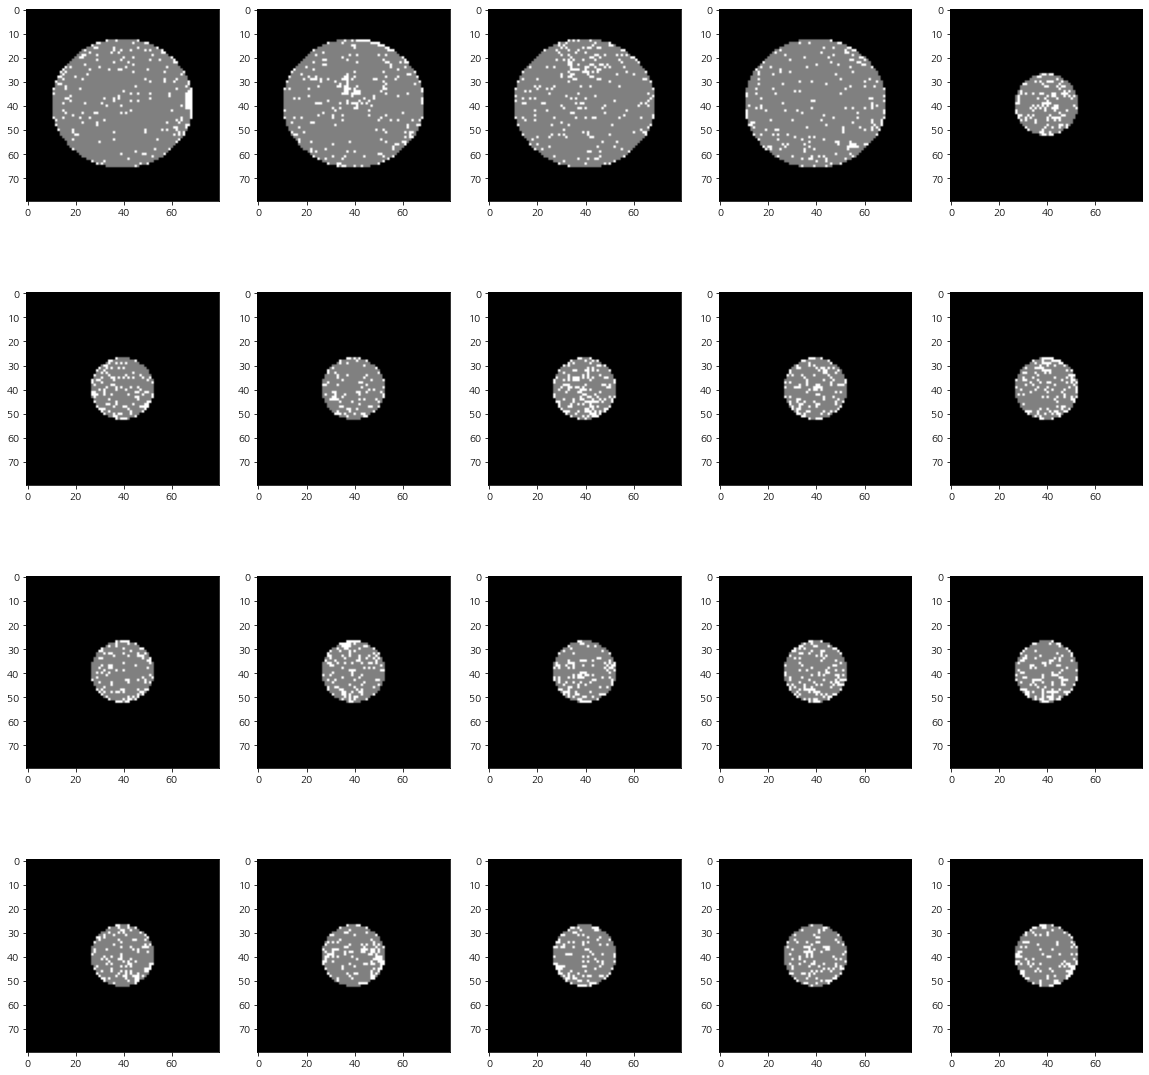

In [37]:
check_failure(df_real)

### 이렇게 모든 결측 모양이 있는 df를 찾아 낼려면 끝도 없을 꺼 같아서 model.predict()을 이용하기로 결정
***1. 가장 이상적인 모델이였던 m_cnn5_rate를 사용***

***2. cat.codes에서 어떤 failure_type가 어떤 코드로 변환이 되었는지 확인이 필요***

***3. predict()를 적용시켜 각각 인식한 웨이퍼의 결측 패턴을 확인***

In [25]:
# 어떤 failure_type이 무슨 code인지 확인
np.unique(df_train['failure_type'], return_counts = True)

(array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
        'Random', 'Scratch', 'none'], dtype=object),
 array([ 3415,   408,  2355,  7856,  1487,    54,   595,   394, 36341]))

In [26]:
np.unique(y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int8),
 array([ 3415,   408,  2355,  7856,  1487,    54,   595,   394, 36341]))

***0 - Center, 
1 - Donut,
2 - Edge-Loc
3 - Edge-Ring,
4 - Loc,
5 - Near-full
6 - Random,
7 - Scratch,
8 - none***

In [27]:
X_re = df_real['wafermap_reshape'].apply(lambda x: np.array(x))

In [28]:
X_real = np.array([x for x in X_re[:30000]])

In [29]:
pred = m_cnn5_rate.predict(X_real)

938/938 [==============================] - 3s 3ms/step


In [30]:
pred_shape = np.argmax(pred, axis = 1)

In [43]:
print(np.unique(pred_shape, return_counts = True))
center_index = np.random.choice(np.array(np.where(pred_shape==0)[0]), size = 5, replace = False) # replace는 비복원 추출

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([  731,     2,  1159,   793,   684,   184,  1785,     9, 24653]))


# df_real데이터에서 Center로 인식한 웨이퍼

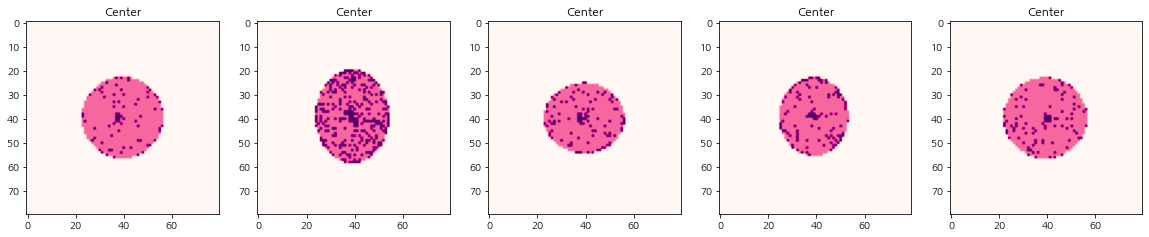

In [50]:
fig, axes = plt.subplots(1,5, figsize = (20, 8))
for i in range(len(center_index)):
    index = center_index[i]
    axes[i].imshow(X_real[index], cmap = 'RdPu')
    axes[i].set_title('Center')

# df_real데이터에서 Donut로 인식한 웨이퍼

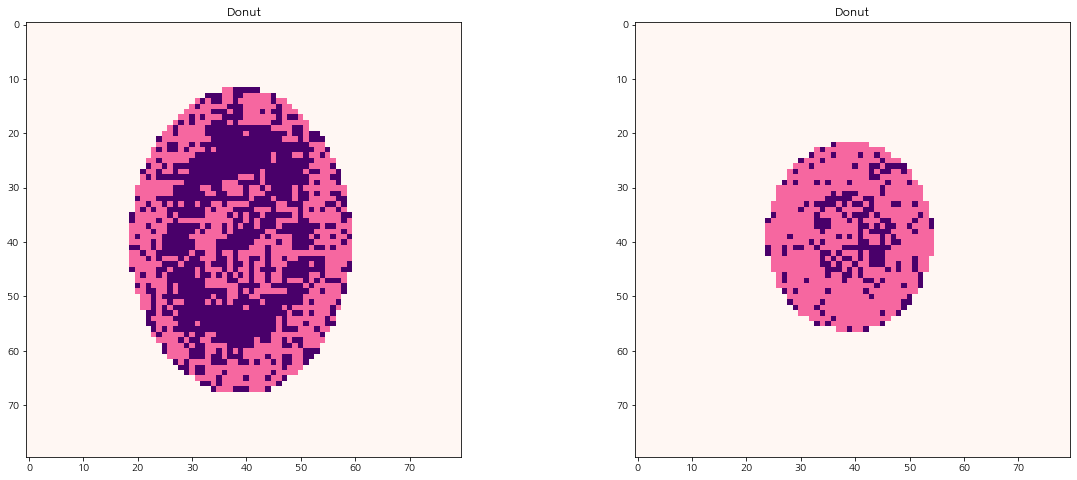

In [64]:
donut_index = np.random.choice(np.array(np.where(pred_shape==1)[0]), size = 2, replace = False) # replace는 비복원 추출
fig, axes = plt.subplots(1,2, figsize = (20, 8))
for i in range(len(donut_index)):
    index = donut_index[i]
    axes[i].imshow(X_real[index], cmap = 'RdPu')
    axes[i].set_title('Donut')

# df_real데이터에서 Edge-Loc로 인식한 웨이퍼

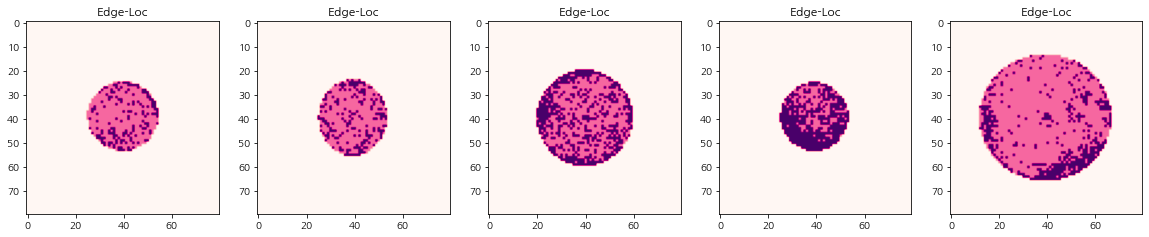

In [87]:
EL_index = np.random.choice(np.array(np.where(pred_shape==2)[0]), size = 5, replace = False) # replace는 비복원 추출
fig, axes = plt.subplots(1,5, figsize = (20, 8))
for i in range(len(EL_index)):
    index = EL_index[i]
    axes[i].imshow(X_real[index], cmap = 'RdPu')
    axes[i].set_title('Edge-Loc')

# df_real데이터에서 Edge-Ring로 인식한 웨이퍼

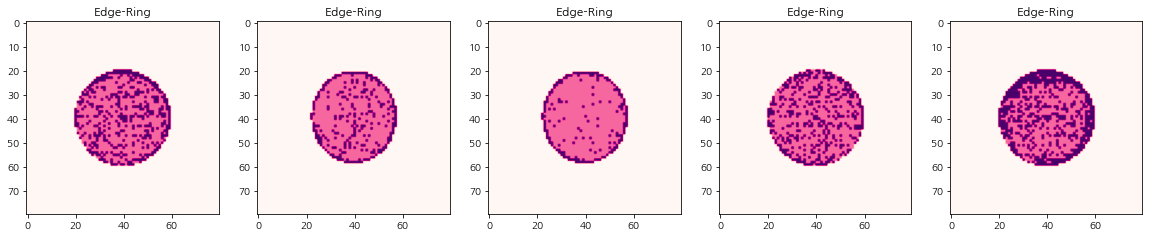

In [90]:
ER_index = np.random.choice(np.array(np.where(pred_shape==3)[0]), size = 5, replace = False) # replace는 비복원 추출
fig, axes = plt.subplots(1,5, figsize = (20, 8))
for i in range(len(ER_index)):
    index = ER_index[i]
    axes[i].imshow(X_real[index], cmap = 'RdPu')
    axes[i].set_title('Edge-Ring')

# df_real데이터에서 Loc로 인식한 웨이퍼

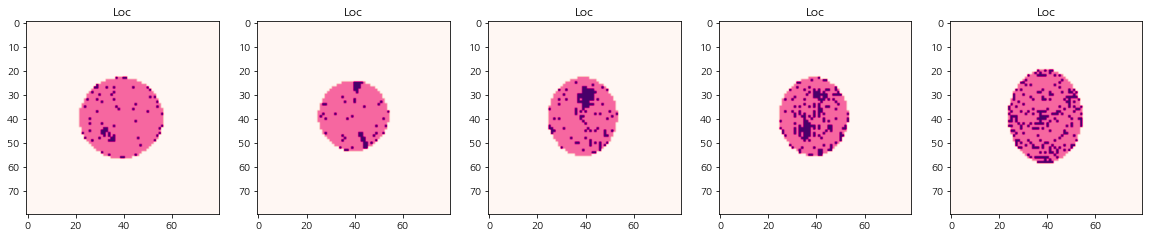

In [93]:
L_index = np.random.choice(np.array(np.where(pred_shape==4)[0]), size = 5, replace = False) # replace는 비복원 추출
fig, axes = plt.subplots(1,5, figsize = (20, 8))
for i in range(len(L_index)):
    index = L_index[i]
    axes[i].imshow(X_real[index], cmap = 'RdPu')
    axes[i].set_title('Loc')

# df_real데이터에서 Near-full로 인식한 웨이퍼

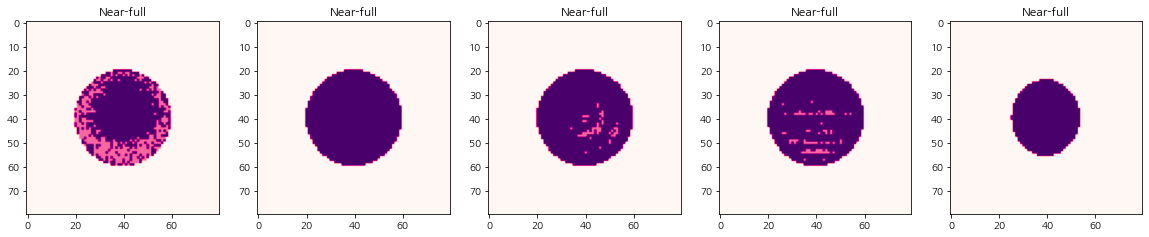

In [94]:
NF_index = np.random.choice(np.array(np.where(pred_shape==5)[0]), size = 5, replace = False) # replace는 비복원 추출
fig, axes = plt.subplots(1,5, figsize = (20, 8))
for i in range(len(NF_index)):
    index = NF_index[i]
    axes[i].imshow(X_real[index], cmap = 'RdPu')
    axes[i].set_title('Near-full')

# df_real데이터에서 Random로 인식한 웨이퍼

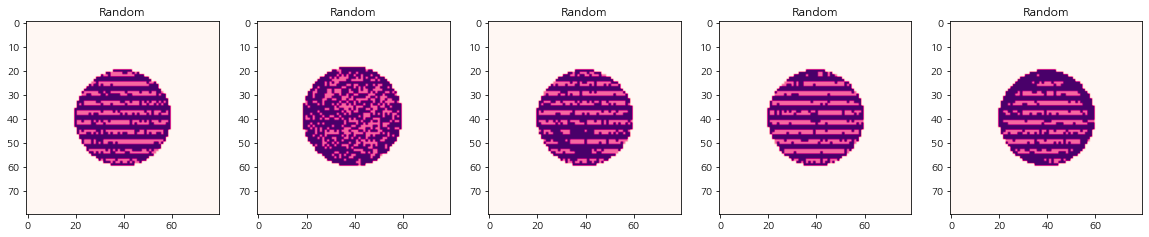

In [98]:
Ran_index = np.random.choice(np.array(np.where(pred_shape==6)[0]), size = 5, replace = False) # replace는 비복원 추출
fig, axes = plt.subplots(1,5, figsize = (20, 8))
for i in range(len(Ran_index)):
    index = Ran_index[i]
    axes[i].imshow(X_real[index], cmap = 'RdPu')
    axes[i].set_title('Random')

# df_real데이터에서 Scratch로 인식한 웨이퍼

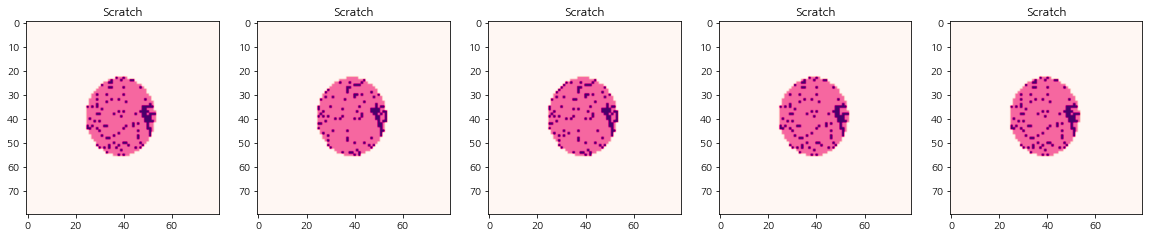

In [103]:
Sc_index = np.random.choice(np.array(np.where(pred_shape==7)[0]), size = 5, replace = False) # replace는 비복원 추출
fig, axes = plt.subplots(1,5, figsize = (20, 8))
for i in range(len(Sc_index)):
    index = Sc_index[i]
    axes[i].imshow(X_real[index], cmap = 'RdPu')
    axes[i].set_title('Scratch')

# df_real데이터에서 none로 인식한 웨이퍼

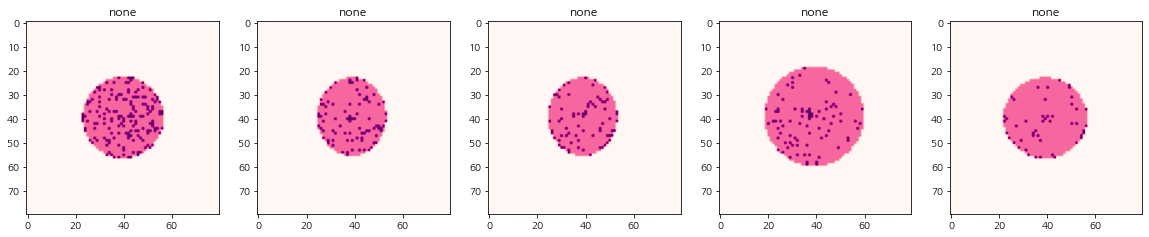

In [104]:
none_index = np.random.choice(np.array(np.where(pred_shape==8)[0]), size = 5, replace = False) # replace는 비복원 추출
fig, axes = plt.subplots(1,5, figsize = (20, 8))
for i in range(len(none_index)):
    index = none_index[i]
    axes[i].imshow(X_real[index], cmap = 'RdPu')
    axes[i].set_title('none')

# 대부분 잘 분류 한다는 것을 알 수 있다.

In [108]:
conv = m_cnn5_rate.layers[0]

In [110]:
print(conv.weights[0].shape, conv.weights[1].shape)

(5, 5, 1, 32) (32,)
